# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


свыше 7.5 тысяч фото в выборке

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.describe

<bound method NDFrame.describe of        file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]>

In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


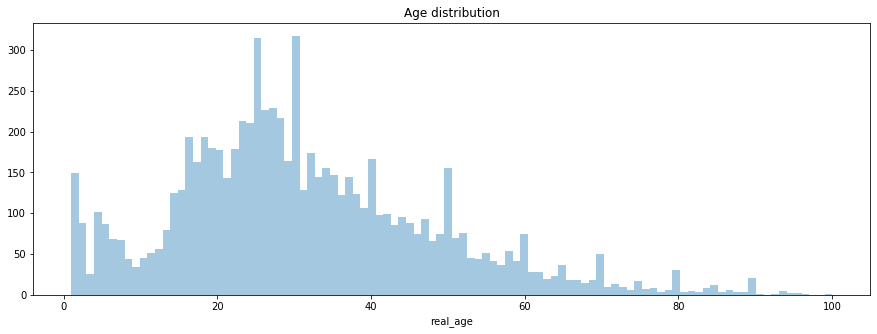

In [6]:
plt.figure(figsize=(15,5))
sns.distplot(labels.real_age, kde = False, bins = 100)
plt.title("Age distribution")
plt.show()

распределение имеет положительный скос (skew), львиная доля фото принадлежит людям в возрастной категории 20-27 лет

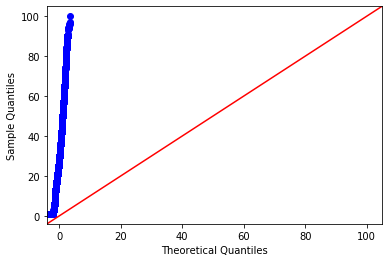

In [7]:
fig = sm.qqplot(labels.real_age, line='45')
plt.show()

распределение не по нормальному закону

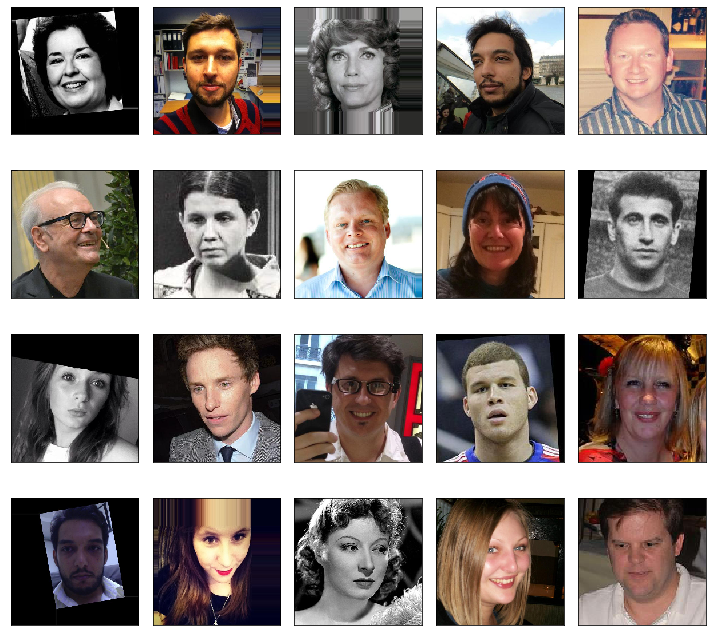

In [10]:
features, target = next(train_gen_flow)
f_ = plt.figure(figsize=(10,10))
for i in range(20):
    f_.add_subplot(4, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

ряд фото под наклоном, также вокругнекоторых фото черный фон, качество и освещение у всех разное, что также может повлиять на предсказательную силу модели.

<div class="alert alert-info">
1. По гистограмме - основная часть данных относится к людям в возрасте 20-27 лет, также мы можем визуально наблюдать пики в круглые возрасты - 25, 35, 50, 60 и 80 лет. полагаю, что это результат обработки данных - возможно, приписывали недостающие числа или вообще округляли. есть достаточно большое количество в диапазоне 1- 5 лет.
2. По фото - особенности следующие, из мужчин нет фото с густой бородой, поэтому, думаю, что модели будет сложно научиться предсказывать возраст данной категории мужчин. касаемо женщин - ни на одном фото нет женщины в очках, возможно, здесь модель также столкнется со сложностями при прогнозировании. в целом качество фото сносное, хотя в некоторых случаях откровенно плохое. думаю, что на результат прогноза также может повлиять освещение в момент снимка, так как освещение везде на фото разное. размер лиц у всех плюс мнус одинаковый. угол поворотта - ряд фото сделано как будто под наклоном, и вокруг них темная рамка, думаю здесь будут также сложности для модели в плане корректного прогнозирования возраста. в силу того, что уже было отмечено ранее - возраст людей на фото в основном 20-27 лет, прогнозирование возраста пожилых людей будет сложнее для модели из-за небольшой выборки. 
</div>

## Обучение модели

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):

    df = pd.read_csv(path + 'labels.csv')
    df = pd.DataFrame(df)
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.25)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    df = pd.read_csv(path + 'labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=0.25)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```
2021-09-23 12:15:09.025903: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-09-23 12:15:09.517716: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2021-09-23 12:15:24.525155: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-09-23 12:15:25.227014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-09-23 12:15:25.227104: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-09-23 12:15:25.227136: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-23 12:15:25.542491: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-09-23 12:15:25.628911: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-09-23 12:15:26.255096: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-09-23 12:15:26.375532: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-09-23 12:15:26.375682: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-09-23 12:15:26.380294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-09-23 12:15:26.380684: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-09-23 12:15:26.572212: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2021-09-23 12:15:26.577455: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4dedd50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-23 12:15:26.577493: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-09-23 12:15:26.955098: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4e73d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-09-23 12:15:26.955137: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2021-09-23 12:15:26.957660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-09-23 12:15:26.957722: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-09-23 12:15:26.957732: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-23 12:15:26.957762: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-09-23 12:15:26.957771: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-09-23 12:15:26.957780: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-09-23 12:15:26.957789: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-09-23 12:15:26.957796: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-09-23 12:15:26.962228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-09-23 12:15:26.973337: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-09-23 12:15:33.756264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-09-23 12:15:33.756312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-09-23 12:15:33.756320: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-09-23 12:15:33.777505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2021-09-23 12:16:10.617309: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-23 12:16:14.439486: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 115s - loss: 208.3048 - mae: 10.5413 - val_loss: 395.9848 - val_mae: 14.9032
Epoch 2/20
356/356 - 39s - loss: 64.7639 - mae: 6.1566 - val_loss: 130.0342 - val_mae: 8.8623
Epoch 3/20
356/356 - 38s - loss: 33.6694 - mae: 4.4887 - val_loss: 82.2220 - val_mae: 6.7726
Epoch 4/20
356/356 - 37s - loss: 22.6080 - mae: 3.6364 - val_loss: 77.2475 - val_mae: 6.5765
Epoch 5/20
356/356 - 37s - loss: 18.9366 - mae: 3.3338 - val_loss: 89.9134 - val_mae: 7.3468
Epoch 6/20
356/356 - 38s - loss: 15.0787 - mae: 2.9312 - val_loss: 70.0628 - val_mae: 6.3506
Epoch 7/20
356/356 - 37s - loss: 11.8133 - mae: 2.6089 - val_loss: 73.3709 - val_mae: 6.3602
Epoch 8/20
356/356 - 38s - loss: 9.6317 - mae: 2.3531 - val_loss: 70.9361 - val_mae: 6.3108
Epoch 9/20
356/356 - 37s - loss: 8.7697 - mae: 2.2559 - val_loss: 67.0537 - val_mae: 6.1816
Epoch 10/20
356/356 - 38s - loss: 9.1694 - mae: 2.2848 - val_loss: 66.7647 - val_mae: 6.1038
Epoch 11/20
356/356 - 38s - loss: 10.2119 - mae: 2.3982 - val_loss: 63.8081 - val_mae: 5.9606
Epoch 12/20
356/356 - 37s - loss: 10.3796 - mae: 2.4386 - val_loss: 68.2990 - val_mae: 6.2615
Epoch 13/20
356/356 - 37s - loss: 10.1503 - mae: 2.4018 - val_loss: 66.7835 - val_mae: 6.0429
Epoch 14/20
356/356 - 38s - loss: 9.4280 - mae: 2.2980 - val_loss: 73.7788 - val_mae: 6.2577
Epoch 15/20
356/356 - 37s - loss: 7.6985 - mae: 2.0914 - val_loss: 67.9782 - val_mae: 6.4291
Epoch 16/20
356/356 - 38s - loss: 6.8904 - mae: 1.9873 - val_loss: 65.9705 - val_mae: 6.1592
Epoch 17/20
356/356 - 38s - loss: 7.3129 - mae: 2.0454 - val_loss: 64.7198 - val_mae: 6.0761
Epoch 18/20
356/356 - 38s - loss: 7.3897 - mae: 2.0387 - val_loss: 63.7883 - val_mae: 6.0039
Epoch 19/20
356/356 - 38s - loss: 7.9042 - mae: 2.1183 - val_loss: 74.4576 - val_mae: 6.2825
Epoch 20/20
356/356 - 38s - loss: 7.1165 - mae: 2.0003 - val_loss: 64.0172 - val_mae: 6.0057

```

## Анализ обученной модели

В качестве параметров модли были использованы - validation_split=0.25, размер батчей = 16, целевой размер стандартный (224, 224), было наложено несколько слоев с параметрами units=16, activation='relu' и units=1, activation='relu' в случае со слоем Dense. learning rate взята за 0.0001, метрика проверки качества mae. pf rjkbxtcndj epochs взято 20. По итогам можно сказать, что модель в целом не перегружена в силу того, что значение mae падает с ростом количества epochs , при чем как в наборах обучения, так и в наборах проверки. Была обучена архитектура ResNet50, при этом модель в среднем допускает ошибку равную 6, что можно оценить как неплохой результат -  по условиям задачи если вы получите MAE меньше 7, это будет отличный результат!